In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
orders = pd.read_csv("orders.csv")
all_nodes  = pd.read_csv("nodes.csv")

test_orders = pd.read_csv("test.csv")

In [3]:
test_nodes = all_nodes[all_nodes["Id"].isin(test_orders.Id)].copy()
nodes = all_nodes[all_nodes["Id"].isin(orders.Id)].copy()

## Data Transformation

In [4]:
orders.running_time = pd.to_datetime(orders.running_time)
orders.completed_time = pd.to_datetime(orders.completed_time)

test_orders.running_time = pd.to_datetime(test_orders.running_time)

In [5]:
orders["avg_speed"] = orders.route_distance_km / (orders.delta_time / 3600)

In [6]:
nodes["node_time"] = nodes.distance / ((5 / 18) * nodes.speed)

In [7]:
nodes["nodes_concat"] = nodes['node_start'].astype('str') + nodes['node_finish'].astype('str')
nodes["occurances"] = nodes.nodes_concat.map(nodes.groupby('nodes_concat')["Id"].agg('count'))

In [8]:
orders["expected_time"] = orders.Id.map(nodes.groupby("Id")["node_time"].agg(func=np.sum))

In [9]:
# data taken from https://weatherspark.com/h/d/96562/2022/1/24/Historical-Weather-on-Monday-January-24-2022-in-Odessa-Ukraine#Figures-ColorTemperature

orders['cloud_cover'] = orders.running_time.dt.hour.map({
    0 : 0, # "clear",
    1 : 0, # "clear",
    2 : 2, # "mostly_cloudly",
    3 : 2, # "mostly_cloudly",
    4 : 2, # "mostly_cloudly",
    5 : 2, # "mostly_cloudly",
    6 : 0, # "clear",
    7 : 0, # "clear",
    8 : 1, # "partly_cloudy",
    9 : 1, # "partly_cloudy",
    10 : 2, # "mostly_cloudy",
    11 : 2, # "mostly_cloudy"
    12 : 2, # "mostly_cloudy",
    13 : 3, # "overcast",
    14 : 2, # "mostly_cloudy",
    15 : 1, # "partly_cloudy",
    16 : 1, # "partly_cloudy",
    17 : 1, # "partly_cloudy",
    18 : 1, # "partly_cloudy",
    19 : 2, # "mostly_cloudy",
    20 : 3, # "overcast",
    21 : 3, # "overcast",
    22 : 3, # "overcast",
    23 : 3 # "overcast",
})

orders['snow'] = orders.running_time.dt.hour.map({
    0 : 1, # "light snow ",
    1 : 1, # "light snow",
    2 : 1.3, # "light snow + mist",
    3 : 1, # "light snow",
    4 : 1, # "light snow",
    5 : 1, # "light snow",
    6 : 1, # "light snow",
    7 : 0, # "no data", probably no snowing at all
    8 : 0, # "no data",
    9 : 0, # "no data",
    10 : 0, # "no data",
    11 : 1.3, # "light snow + mist"
    12 : 2.3, # "snow + mist",
    13 : 3, # "heavy snow",
    14 : 3.8, # "heavy snow + mist + drifting snow",
    15 : 2.8, # "snow + mist + drifting snow",
    16 : 2.8, # "snow + mist + drifting snow",
    17 : 1.8, # "light snow + mist + drifting snow",
    18 : 1.3, # "light snow + mist",
    19 : 1.3, # "light snow + mist",
    20 : 1.3, # "light snow + mist",
    21 : 1.3, # "light snow + mist",
    22 : 1.8, # "light snow + mist + drifting snow",
    23 : 1.8 # "light snow + mist + drifting snow",
})

In [10]:
from sklearn.metrics.pairwise import rbf_kernel

orders['running_time'] = orders['running_time'].dt.hour * 60 + orders['running_time'].dt.minute
orders['time_rbf'] = rbf_kernel(orders[['running_time']], [[450]], gamma=0.00002) + rbf_kernel(orders[['running_time']], [[1050]], gamma=0.000006)

## Visualizations

<AxesSubplot: xlabel='avg_speed', ylabel='Count'>

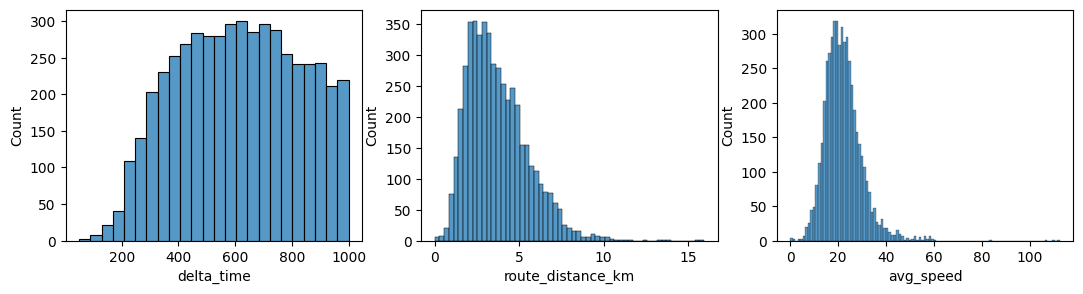

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(13,3))

sns.histplot(orders.delta_time, ax = axs[0])
sns.histplot(orders.route_distance_km, ax = axs[1])
sns.histplot(orders.avg_speed, ax = axs[2])

<AxesSubplot: xlabel='running_time', ylabel='Count'>

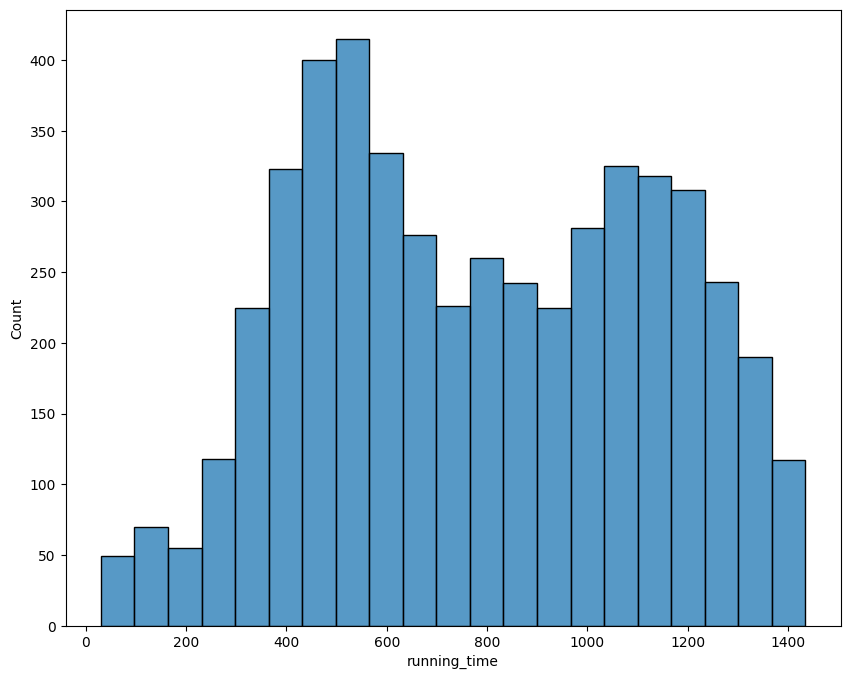

In [12]:
fig, ax = plt.subplots(figsize = (10, 8))
sns.histplot(orders.running_time, ax = ax)

<AxesSubplot: xlabel='snow'>

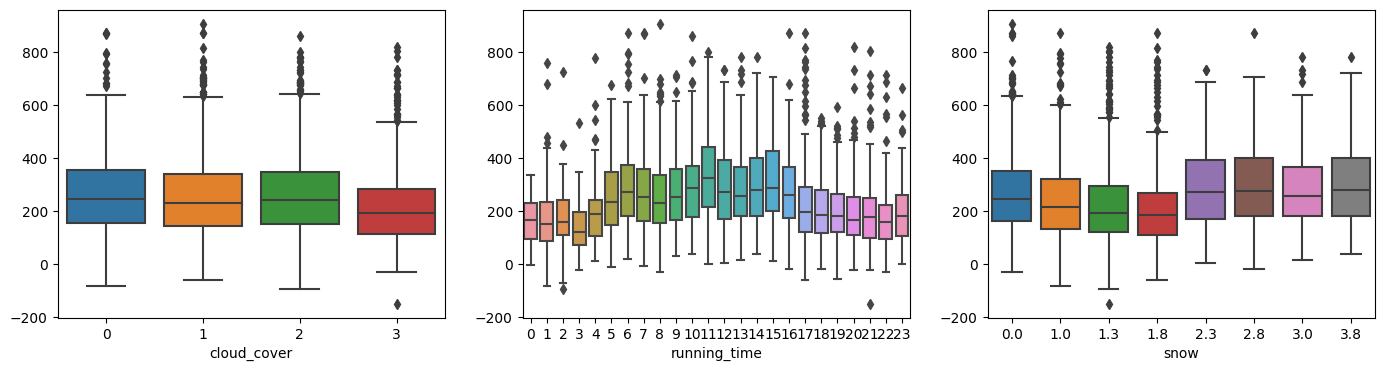

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(17,4))

sns.boxplot(y = orders.delta_time - orders.expected_time, x = orders.cloud_cover, ax = axs[0])
sns.boxplot(x = (orders.running_time / 60).astype(int), y=(orders.delta_time - orders.expected_time), ax = axs[1])
sns.boxplot(x = orders.snow, y = orders.delta_time - orders.expected_time, ax = axs[2])

In [16]:
df = pd.merge(orders, nodes, left_on='Id', right_on='Id')
df

,Id,running_time,completed_time,route_distance_km,delta_time,avg_speed,expected_time,cloud_cover,snow,time_rbf,node_start,node_finish,distance,speed,node_time,nodes_concat,occurances
0,-4773019581999572651,1110,2022-01-24 18:44:43,3.740,862.0,15.619490,445.785429,1,1.3,0.978796,10980417,4768348185,31.771489,30.0,3.812579,109804174768348185,93
1,-4773019581999572651,1110,2022-01-24 18:44:43,3.740,862.0,15.619490,445.785429,1,1.3,0.978796,10980418,1570776947,3.673054,24.0,0.550958,109804181570776947,117
2,-4773019581999572651,1110,2022-01-24 18:44:43,3.740,862.0,15.619490,445.785429,1,1.3,0.978796,10980430,4768348188,15.550612,27.0,2.073415,109804304768348188,68
3,-4773019581999572651,1110,2022-01-24 18:44:43,3.740,862.0,15.619490,445.785429,1,1.3,0.978796,10980431,5125489557,50.034390,29.0,6.211166,109804315125489557,201
4,-4773019581999572651,1110,2022-01-24 18:44:43,3.740,862.0,15.619490,445.785429,1,1.3,0.978796,10980432,5213300015,13.453126,30.0,1.614375,109804325213300015,193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401306,-4845695090750648713,897,2022-01-24 15:11:25,2.323,819.0,10.210989,329.062837,2,3.8,0.887349,8952395527,8952395526,9.279770,24.0,1.391965,89523955278952395526,63
401307,-4845695090750648713,897,2022-01-24 15:11:25,2.323,819.0,10.210989,329.062837,2,3.8,0.887349,8952395528,8952395527,90.006624,18.0,18.001325,89523955288952395527,64
401308,-4845695090750648713,897,2022-01-24 15:11:25,2.323,819.0,10.210989,329.062837,2,3.8,0.887349,8952395529,8952395528,59.390484,20.0,10.690287,89523955298952395528,65
401309,-4845695090750648713,897,2022-01-24 15:11:25,2.323,819.0,10.210989,329.062837,2,3.8,0.887349,8952395530,8952395529,7.099413,24.0,1.064912,89523955308952395529,63


In [17]:
df[(df.node_start == 27128515) & (df.node_finish == 2071748215)]

,Id,running_time,completed_time,route_distance_km,delta_time,avg_speed,expected_time,cloud_cover,snow,time_rbf,node_start,node_finish,distance,speed,node_time,nodes_concat,occurances
318,5964315354301636538,868,2022-01-24 14:35:08,2.867,423.0,24.400000,327.574647,2,3.8,0.850124,27128515,2071748215,12.679597,24.0,1.901940,271285152071748215,9
30810,-8695663553273577005,919,2022-01-24 15:25:26,2.147,365.0,21.175890,275.687134,1,2.8,0.914445,27128515,2071748215,12.679597,23.0,1.984633,271285152071748215,9
79465,5614359627719563656,896,2022-01-24 15:04:44,3.274,488.0,24.152459,416.717069,2,3.8,0.886082,27128515,2071748215,12.679675,22.0,2.074856,271285152071748215,9
154067,-380198223604441514,664,2022-01-24 11:14:07,4.061,595.0,24.570756,410.065287,2,1.3,0.809175,27128515,2071748215,12.679597,30.0,1.521552,271285152071748215,9
174513,-6450531797125061397,1032,2022-01-24 17:22:59,3.487,618.0,20.312621,432.953911,1,1.8,0.999200,27128515,2071748215,12.679597,31.0,1.472469,271285152071748215,9
296050,7594941490194731162,362,2022-01-24 06:07:13,2.161,284.0,27.392958,195.979208,0,1.0,0.914940,27128515,2071748215,12.679597,33.0,1.383229,271285152071748215,9
340021,-7566607897413531552,1313,2022-01-24 21:59:14,2.982,368.0,29.171739,312.882354,3,1.3,0.660331,27128515,2071748215,12.679597,20.0,2.282327,271285152071748215,9
357056,8856335539703089350,754,2022-01-24 12:43:46,4.867,538.0,32.567286,481.585440,2,2.3,0.748645,27128515,2071748215,12.679597,24.0,1.901940,271285152071748215,9
371769,-8493744790195098214,1150,2022-01-24 19:18:35,2.807,457.0,22.112035,324.298972,2,1.3,0.941820,27128515,2071748215,12.679597,22.0,2.074843,271285152071748215,9


In [18]:
features = df[['cloud_cover', 'snow', 'time_rbf', 'distance', 'speed', 'occurances']].copy()
target = df.distance / (df.avg_speed / 0.36)